## Описание проекта

Создание модели для прогнозированиея сердечной недостаточности

### Структура данных

`Age`: возраст пациента [years]

`Sex`: пол пациента [M: Male, F: Female]

`ChestPainType`: тип боли в груди [TA: Типичная стенокардия, ATA: Атипичная стенокардия, NAP: неангинальная боль, ASY: Бессимптомная] [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

`RestingBP`: кровяное давление в состоянии покоя [мм рт. ст.] [mm Hg]

`Cholesterol`: сывороточный холестерин [мм/дл] / serum cholesterol [mm/dl]

`FastingBS`: уровень сахара в крови натощак [1: если уровень сахара в крови натощак > 120 мг/дл, 0: в противном случае] / fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

`RestingECG`: электрокардиограммы в покое [Нормальный: Нормальный, ST: аномалия зубца ST-T (инверсии зубца T и/или подъем или депрессия ST > 0,05 мВ), ГЛЖ: вероятная или определенная гипертрофия левого желудочка по критериям Эстеса] / resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

`MaxHR`: достигнутая максимальная частота сердечных сокращений [числовое значение от 60 до 202] / maximum heart rate achieved [Numeric value between 60 and 202]

`ExerciseAngina`: стенокардия, вызванная физической нагрузкой [Y: Да, N: Нет] / exercise-induced angina [Y: Yes, N: No]

`Oldpeak`: oldpeak = ST [Numeric value measured in depression]

`ST_Slope`: наклон сегмента ST пикового упражнения [Вверх: наклон вверх, плоский: плоский, Вниз: наклон вниз] / the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

`HeartDisease`: output class [1: heart disease, 0: Normal]

## Импортируемые библиотеки

In [247]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as gb_cl
import xgboost as xgb
from catboost import CatBoostClassifier as cat_cl

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV

## Чтение данных

In [248]:
data = pd.read_csv('heart.csv')

In [249]:
data.shape

(918, 12)

In [250]:
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [251]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Данные прочитались номально. Можно присутпать к EDA

## EDA

### Анализ структуры датасета

- на этом этапе оценим какие типы данных представлены

- получим количественные характеристики для столбцов

In [252]:
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [253]:
pd.value_counts(data.dtypes)

int64      6
object     5
float64    1
dtype: int64

Сначала посмотрим на нечисловые столбцы

In [254]:
data.describe(exclude="number")

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


Наблюдается следующий дисбаланс столбцам:

- В столбце `Sex` в основном представлены мужчины

- В столбце `ChestPainType` в основном представлено значение `ASY`

- В столбце `RestingECG` в основном представлено значение `Normal`

- В столбце `ST_Slope` в основном представлено значение `Flat`

Теперь оценим ситуацию с числовыми столбцами

In [255]:
uniq_values = data.select_dtypes(include='number').nunique().sort_values()

In [256]:
uniq_values

FastingBS         2
HeartDisease      2
Age              50
Oldpeak          53
RestingBP        67
MaxHR           119
Cholesterol     222
dtype: int64

- Как и предполагалось у нас две бинарные переменные - целевая `HeartDisease` и `FastingBS`

- Остальные стообцы выглядят нормальными численными переменными

In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Пропусков не наблюдается

In [258]:
len(data[data.duplicated()])

0

Дубликатов не наблюдается

#### Предварительые выводы

- данные загрузились в соотвествии с описанием по количеству экземпляров измерений и переменных

- неколичественных переменных наюблюдается определёный дисбаланс (л=ометим его на будущее):
  - В столбце `Sex` в основном представлены мужчины

  - В столбце `ChestPainType` в основном представлено значение `ASY`

  - В столбце `RestingECG` в основном представлено значение `Normal`

  - В столбце `ST_Slope` в основном представлено значение `Flat`
  
- Численные стообцы выглядят нормальными численными переменными

- Пропусков и дубликатов в датасете не наблюдается

### Графическое представление данных

На данном шаге мы представим числовые и нечисловые данные графически и посмотрим есть ли что-то на что соит обратить внимание

Сначала посмотрим на числовые данные

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

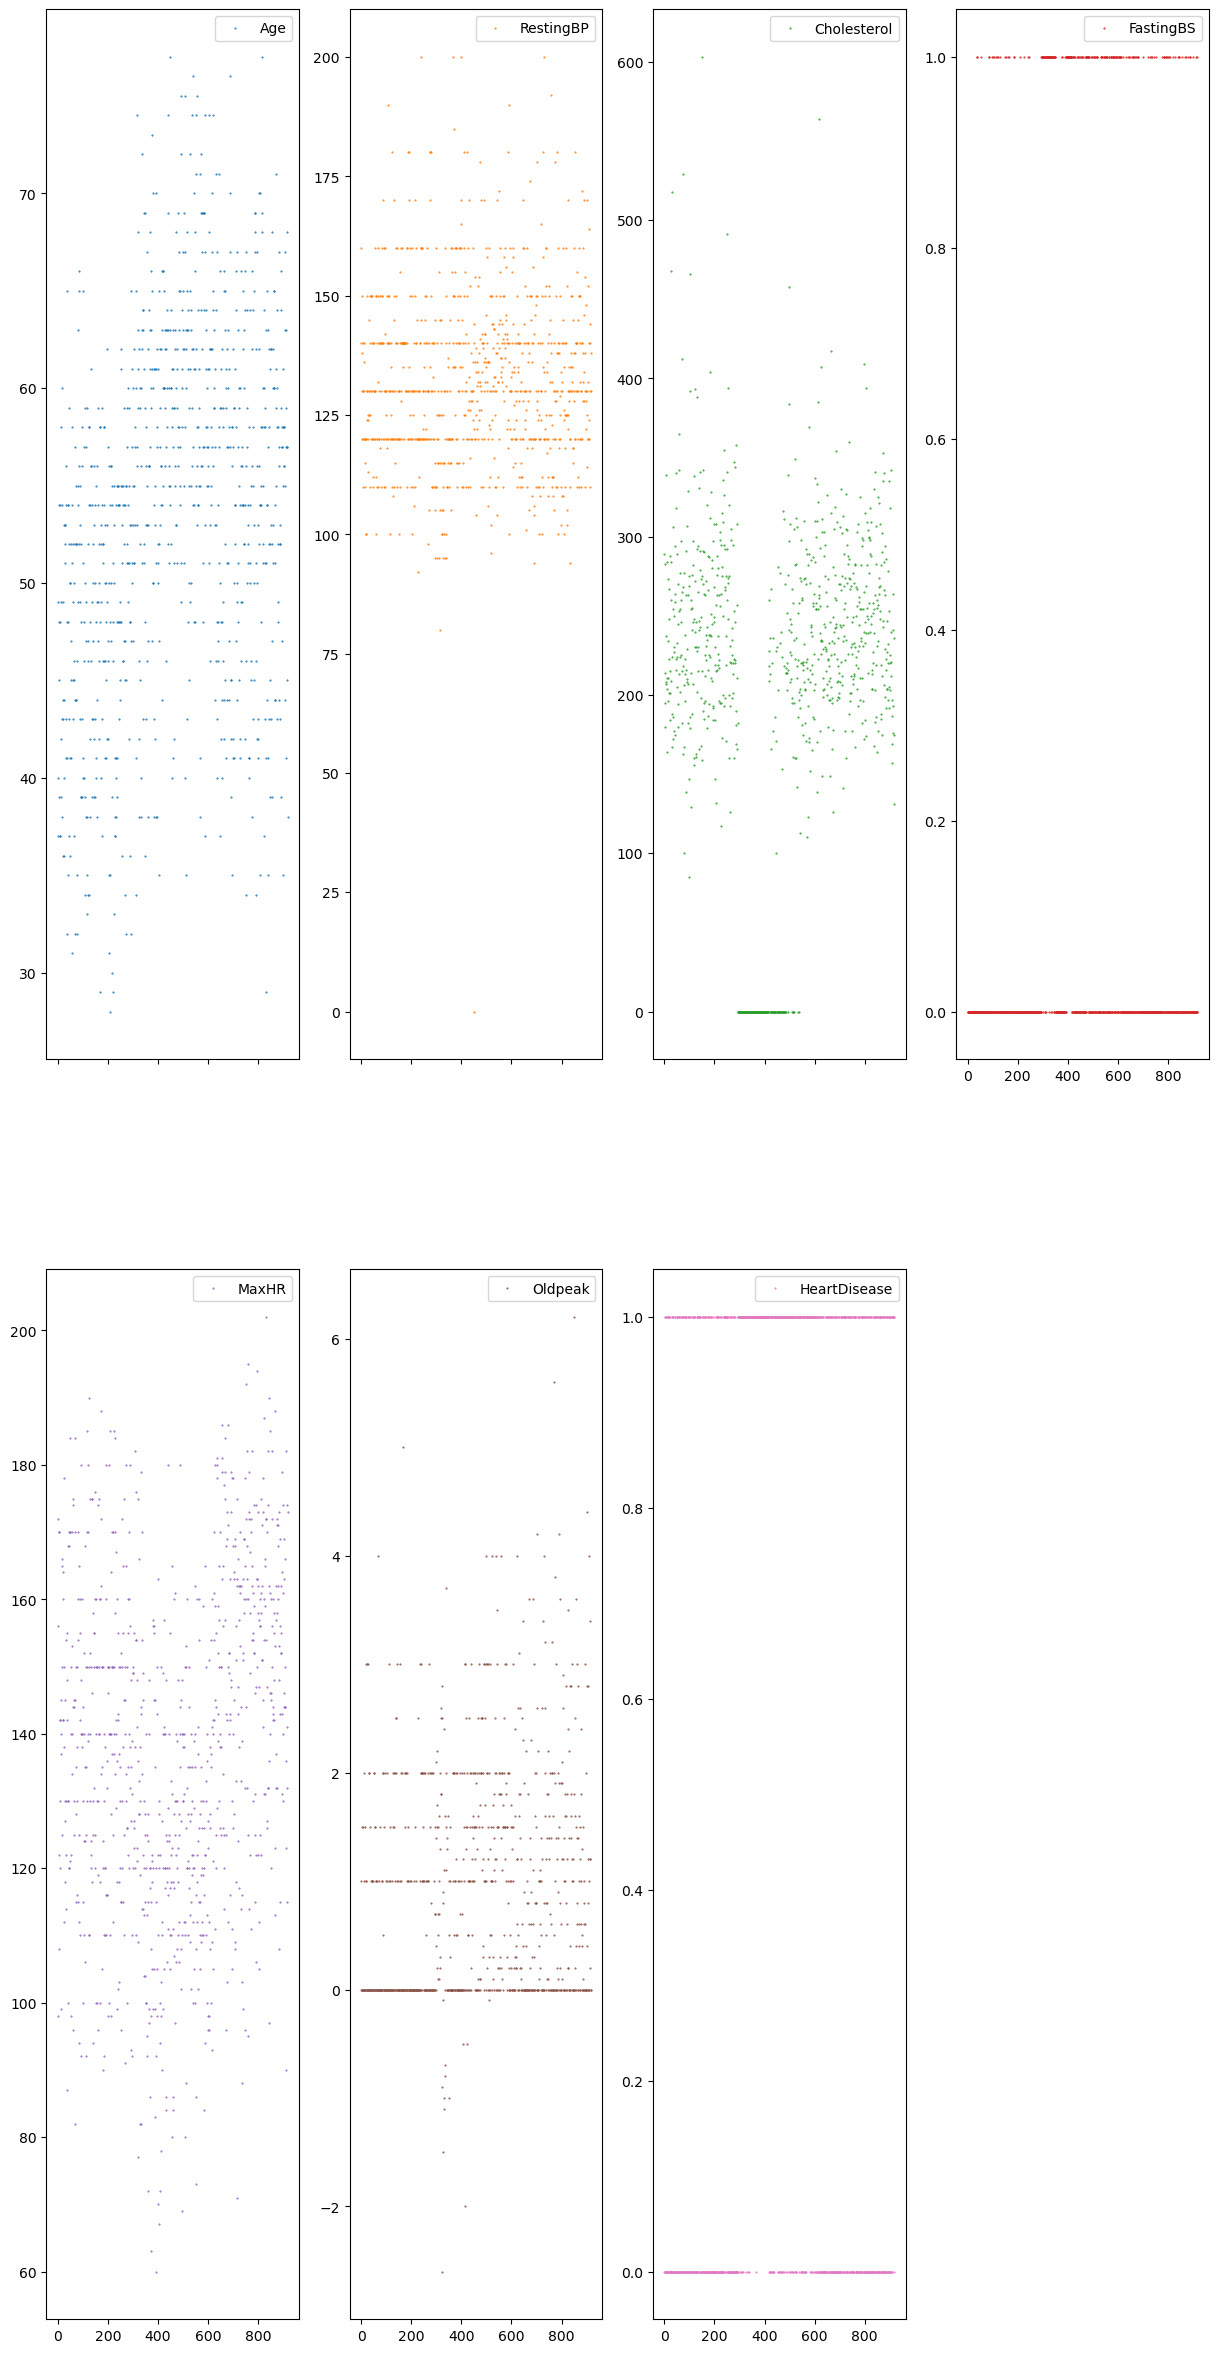

In [259]:
data.plot(
          lw=0,
          marker=".",
          subplots=True,
          layout=(-1, 4),
          figsize=(15, 30),
          markersize=1
         )

In [260]:
num_cols = data.select_dtypes(include=np.number).columns.tolist()

Age


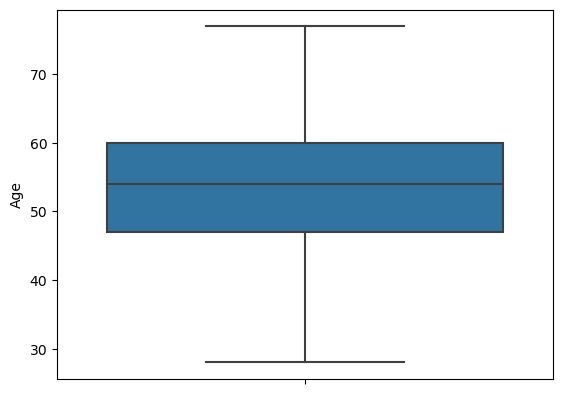

--------------------------------------------------

RestingBP


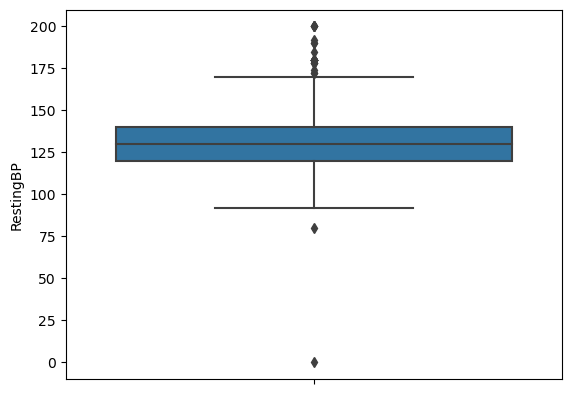

--------------------------------------------------

Cholesterol


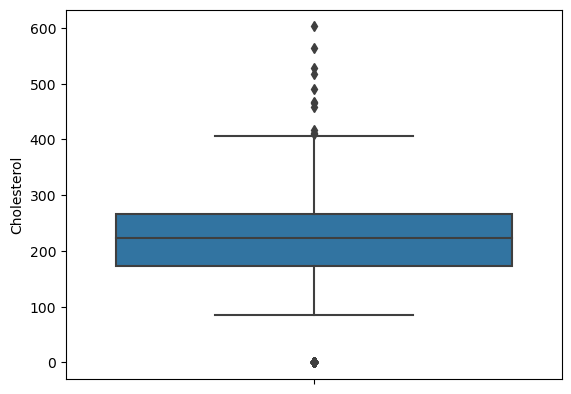

--------------------------------------------------

FastingBS


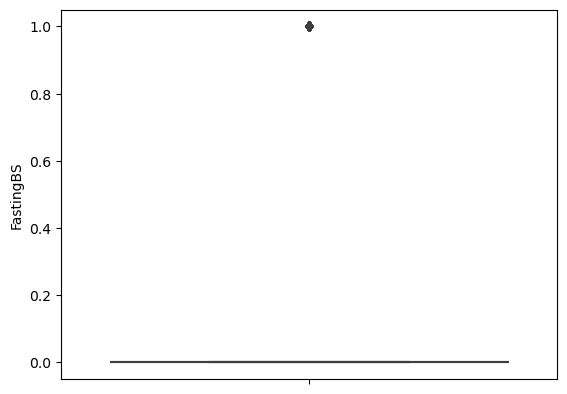

--------------------------------------------------

MaxHR


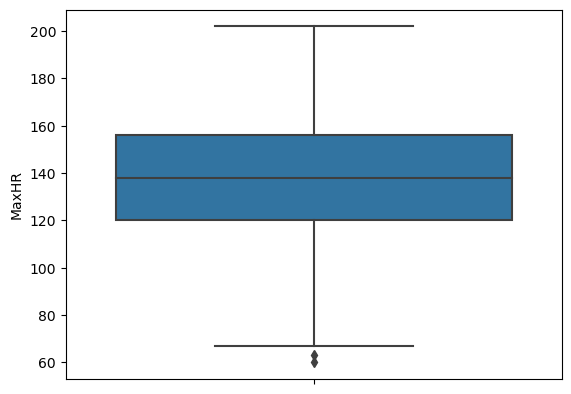

--------------------------------------------------

Oldpeak


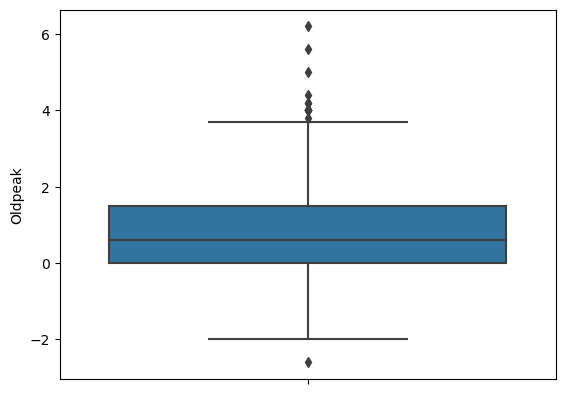

--------------------------------------------------

HeartDisease


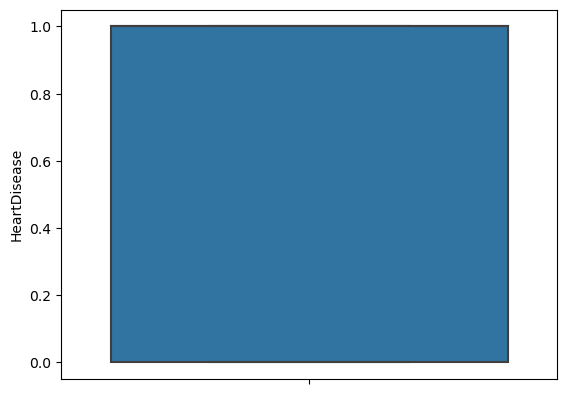

--------------------------------------------------



In [261]:
for col in num_cols:
    print(col)
    sns.boxplot(y=data[col])
    plt.show()
    print('-' * 50)
    print()

- Пока ничего очень странного в числовых данных не наблюдается

- Видны определённые выбросы но это очевидно те эктремальные значения с которые определяют фазы болезни поэтому не будем сними бороться

Посмотрим на нечисловые данные

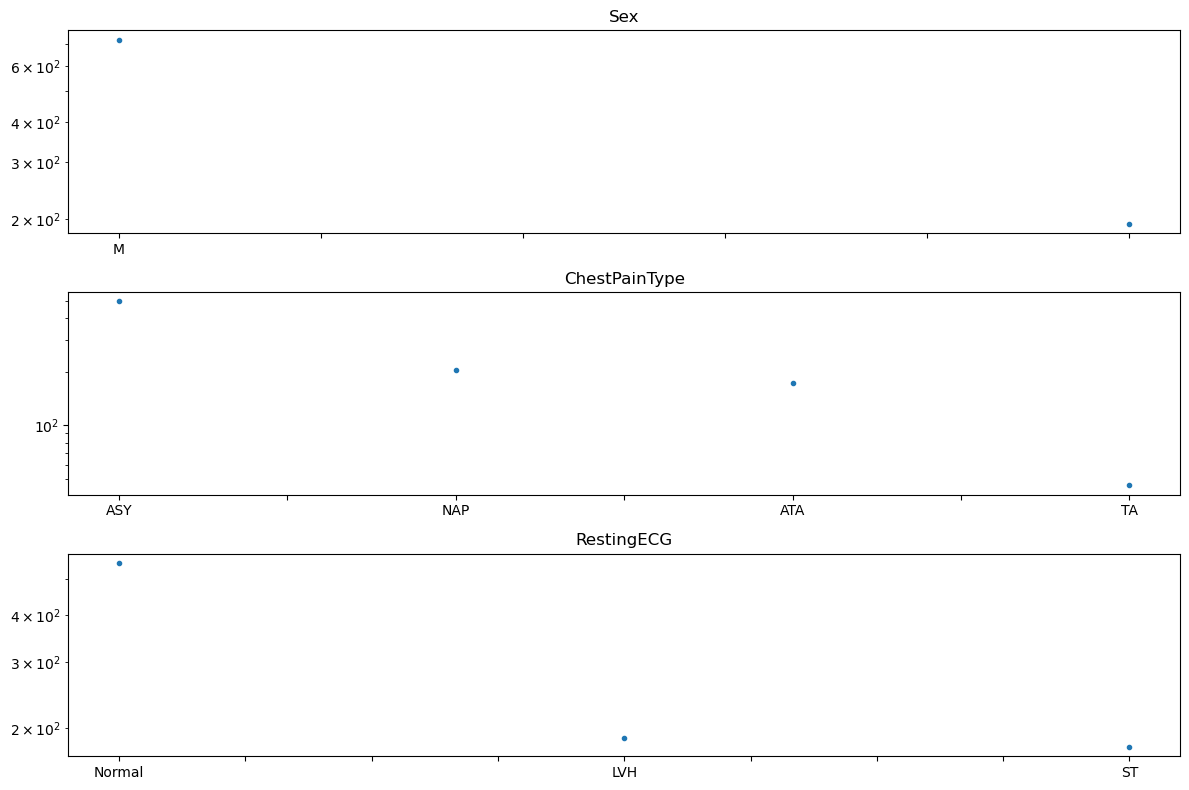

In [262]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12, 8))

df_non_numerical = data.select_dtypes(exclude=["number", "datetime"])

for col, ax in zip(df_non_numerical.columns, axes.ravel()):
    df_non_numerical[col].value_counts().plot(logy=True, title=col, lw=0, marker=".", ax=ax)
    
plt.tight_layout();

- В нечисловых данных также не набллюдается ничего странного

- Видны ранее отмеченные перекосы в значениях категориальных переменных, отметим это и посмотрим что с этим делать позднее

#### Предварительные выводы

- Пока ничего очень странного в числовых данных не наблюдается

- Видны определённые выбросы но это очевидно те эктремальные значения с которые определяют фазы болезни поэтому не будем сними бороться

- В нечисловых данных также не набллюдается ничего странного

- Видны ранее отмеченные перекосы в значениях категориальных переменных, отметим это и посмотрим что с этим делать позднее

### Оценка контента данных

- На данном шаге мы попытаемся изучить какие-то свойства данных (например распределение) и посмотреть какие выводы можно сделать

- Также оценим взяимосвязь между данными

Оценим распределение числовых данных

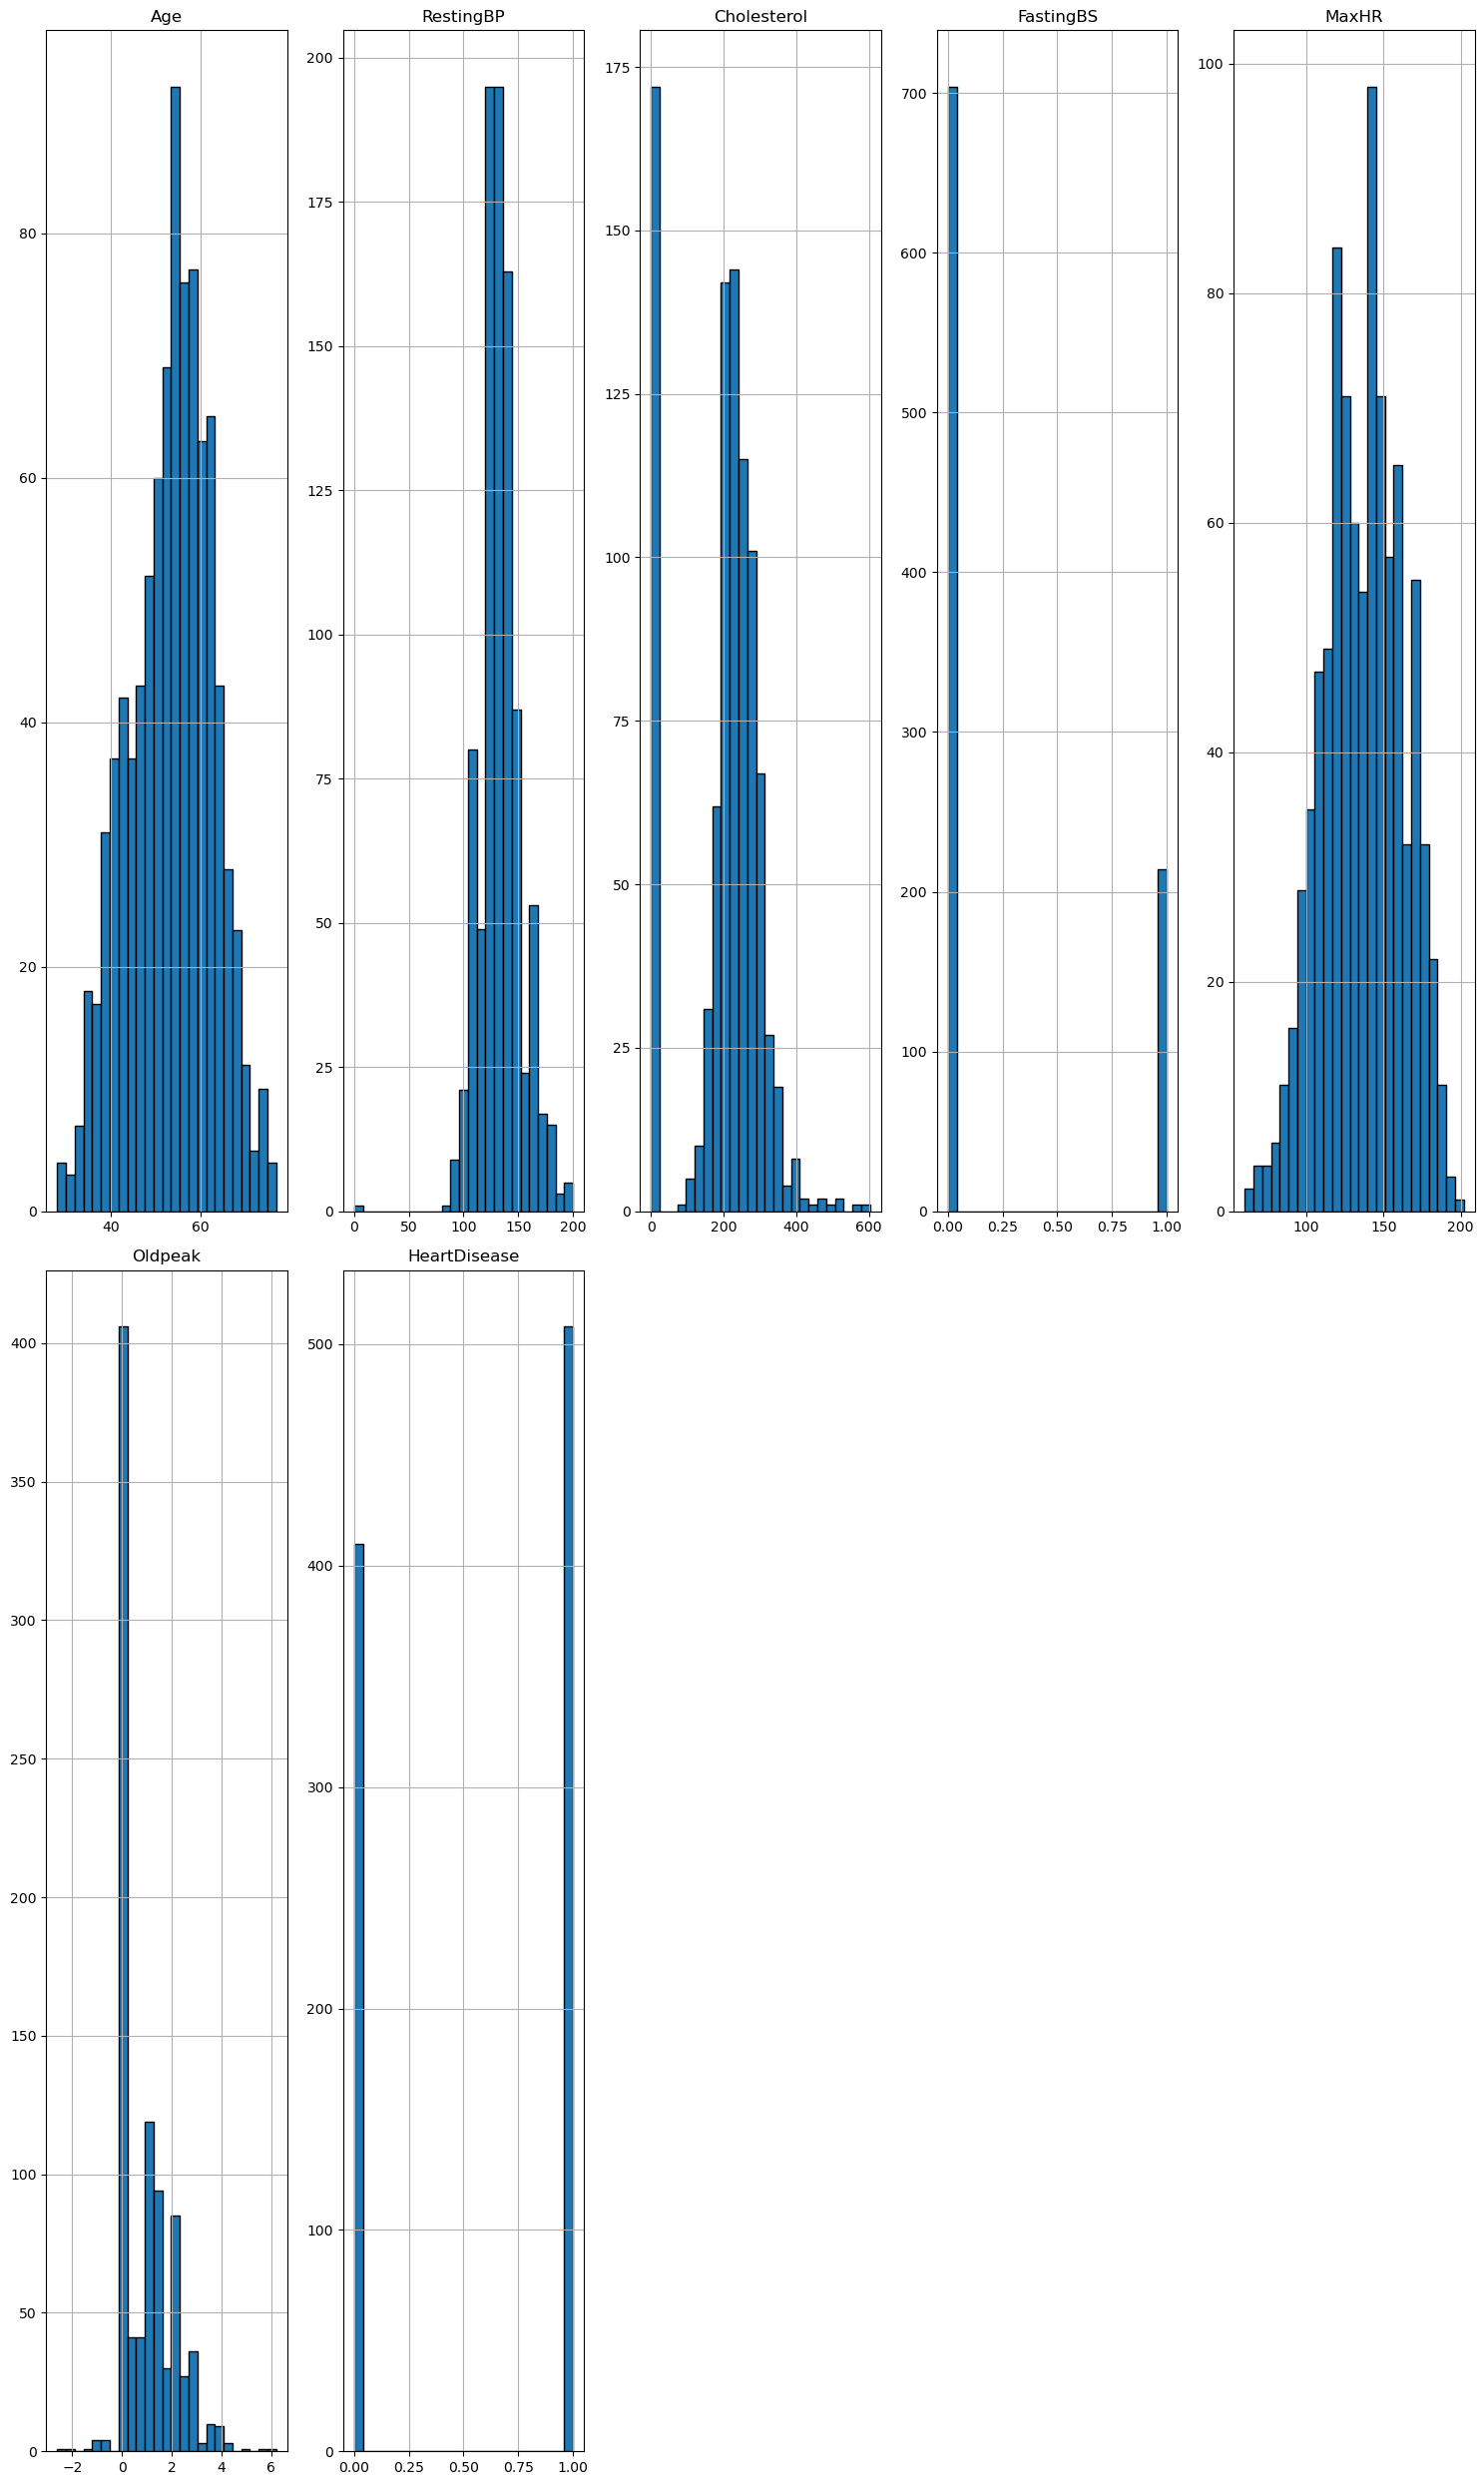

In [263]:
data.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor='black')
plt.tight_layout()

Посмотрим немного на странности в `Cholesterol` и `Oldpeak`

In [264]:
df = data.query('Cholesterol == 0')

Значение `0` выглядит странно для холестерина

In [265]:
len(df)

172

In [266]:
len(df[df['HeartDisease'] == 1])

152

Большинство тех у кого уровень холестерина 0, диагнастируются с Сердечно-сосудистыми заболеваниями

In [267]:
d = df[df['HeartDisease'] == 0]

In [268]:
d

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
301,55,M,ATA,140,0,0,ST,150,N,0.2,Up,0
307,53,M,ATA,130,0,0,ST,120,N,0.7,Down,0
310,65,M,ASY,155,0,0,Normal,154,N,1.0,Up,0
314,53,M,ASY,80,0,0,Normal,141,Y,2.0,Down,0
326,45,M,NAP,110,0,0,Normal,138,N,-0.1,Up,0
332,38,M,NAP,100,0,0,Normal,179,N,-1.1,Up,0
336,72,M,NAP,160,0,0,LVH,114,N,1.6,Flat,0
364,56,M,NAP,120,0,0,Normal,97,N,0.0,Flat,0
421,66,M,NAP,120,0,0,ST,120,N,-0.5,Up,0
423,60,M,NAP,180,0,0,ST,140,Y,1.5,Flat,0


сложно сказать о чём говорит 0 холестерина при отсутствии Сердечно-сосудистых заболеваний

In [269]:
data['Oldpeak'].describe()

count    918.000000
mean       0.887364
std        1.066570
min       -2.600000
25%        0.000000
50%        0.600000
75%        1.500000
max        6.200000
Name: Oldpeak, dtype: float64

In [270]:
df = data.query('Oldpeak == 0')

In [271]:
len(df)

368

In [272]:
len(df[df['HeartDisease'] == 1])

124

In [273]:
len(df[df['HeartDisease'] == 0])

244

In [274]:
df.corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254791,-0.161743,0.238542,-0.420835,NaN,0.332569
RestingBP,0.254791,1.000000,-0.040902,0.090133,-0.093947,NaN,0.106060
Cholesterol,-0.161743,-0.040902,1.000000,-0.203880,0.375104,NaN,-0.350019
FastingBS,0.238542,0.090133,-0.203880,1.000000,-0.197725,NaN,0.281654
MaxHR,-0.420835,-0.093947,0.375104,-0.197725,1.000000,NaN,-0.360184
Oldpeak,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeartDisease,0.332569,0.106060,-0.350019,0.281654,-0.360184,NaN,1.000000


Также не понятно что можно / нужно с этим делать

- Все переменные (за исключением категориальных) имеют признаки нормального распределения, что видимо неплохо для дальнейгего процесса построения модели

- Два стообца (`Cholesterol` и `Oldpeak`) имеют какие-то интересные ярковыраженные дополнительные пики, отметим это для возможного дальнейшего использования

In [275]:
df_num = data.select_dtypes(include="number").nunique() >= 25

In [276]:
df_num = data[df_num[df_num].index]

In [277]:
df_num.shape

(918, 5)

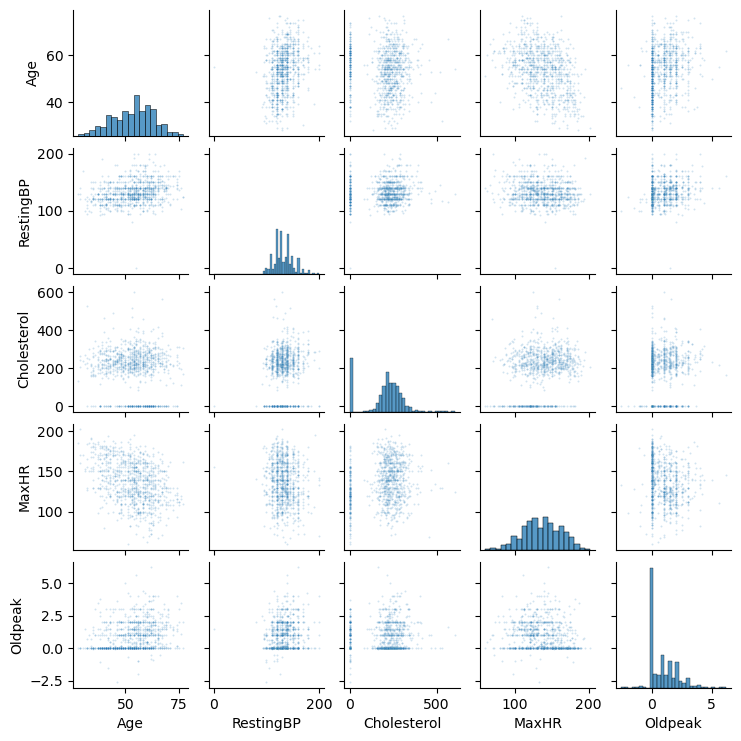

In [278]:
sns.pairplot(
             df_num,
             height=1.5,
             plot_kws={'s':2, 'alpha': 0.2},
)

Не наблюдается каких-то слишком линейных зависимостей между переменными

Оценим взаимосвязь переменных вычислив корреляции

In [279]:
df_corr = data.corr()

In [280]:
df_corr

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000


<AxesSubplot:>

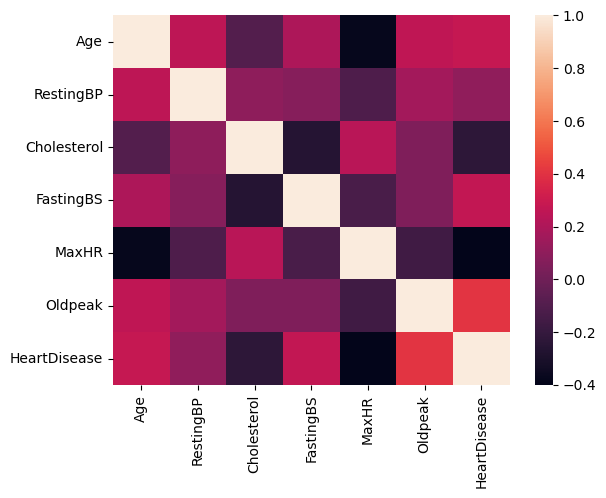

In [281]:
sns.heatmap(df_corr)

- отсутствуют сильно коррелирющие переменные (как положительные так и отрицательные)

- есть переменные у которых наблюдается средняя корреляция в районе +/- 0.4 но не будем ничего делать по данному поводу

#### Предварительные выводы

- Все переменные (за исключением категориальных) имеют признаки нормального распределения, что видимо неплохо для дальнейгего процесса построения модели

- Два стообца (`Colesterol` и `Oldpeak`) имеют какие-то интересные ярковыраженные дополнительные пики, отметим это для возможного дальнейшего использования

- Не наблюдается каких-то слишком линейных зависимостей между переменными

- отсутствуют сильно коррелирющие переменные (как положительные так и отрицательные)

- есть переменные у которых наблюдается средняя корреляция в районе +/- 0.4 но не будем ничего делать по данному поводу

### Выводы: EDA

- данные загрузились в соотвествии с описанием по количеству экземпляров измерений и переменных

- неколичественных переменных наюблюдается определёный дисбаланс (л=ометим его на будущее):
  - В столбце `Sex` в основном представлены мужчины

  - В столбце `ChestPainType` в основном представлено значение `ASY`

  - В столбце `RestingECG` в основном представлено значение `Normal`

  - В столбце `ST_Slope` в основном представлено значение `Flat`
  
- Численные стообцы выглядят нормальными численными переменными

- Пропусков и дубликатов в датасете не наблюдается

- Пока ничего очень странного в числовых данных не наблюдается

- Видны определённые выбросы но это очевидно те эктремальные значения с которые определяют фазы болезни поэтому не будем сними бороться

- В нечисловых данных также не набллюдается ничего странного

- Видны ранее отмеченные перекосы в значениях категориальных переменных, отметим это и посмотрим что с этим делать позднее

- Все переменные (за исключением категориальных) имеют признаки нормального распределения, что видимо неплохо для дальнейгего процесса построения модели

- Два стообца (`Colesterol` и `Oldpeak`) имеют какие-то интересные ярковыраженные дополнительные пики, отметим это для возможного дальнейшего использования

- Не наблюдается каких-то слишком линейных зависимостей между переменными

- отсутствуют сильно коррелирющие переменные (как положительные так и отрицательные)

- есть переменные у которых наблюдается средняя корреляция в районе +/- 0.4 но не будем ничего делать по данному поводу

## Подготовка данных для обучения модели

На данном шаге мы произведём следущие действия:

- кодировку категориальных данных (скорее всего методом OHE)

- масштабирование численных признаков

- возможную балансировку классов (для целевой перемнной)

### Кодировка категориальных данных

In [282]:
data.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [283]:
data.shape

(918, 12)

In [284]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [285]:
data_ohe.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [286]:
data_ohe.shape

(918, 16)

In [287]:
target = data_ohe['HeartDisease']
features_ohe = data_ohe.drop('HeartDisease', axis=1)

In [288]:
print(target.shape)
print(features_ohe.shape)

(918,)
(918, 15)


### Масштабирование

In [289]:
scaler = StandardScaler()

In [290]:
numeric = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [291]:
features_ohe_scaled = features_ohe.copy()

In [292]:
scaler.fit(features_ohe[numeric])

StandardScaler()

In [293]:
features_ohe_scaled[numeric] = scaler.transform(features_ohe_scaled[numeric])

In [294]:
features_ohe_scaled.head(10)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,0,1.382928,-0.832432,1,1,0,0,1,0,0,0,1
1,-0.478484,1.491752,-0.171961,0,0.754157,0.105664,0,0,1,0,1,0,0,1,0
2,-1.751359,-0.129513,0.770188,0,-1.525138,-0.832432,1,1,0,0,0,1,0,0,1
3,-0.584556,0.302825,0.139040,0,-1.132156,0.574711,0,0,0,0,1,0,1,1,0
4,0.051881,0.951331,-0.034755,0,-0.581981,-0.832432,1,0,1,0,1,0,0,0,1
5,-1.539213,-0.669935,1.282424,0,1.304332,-0.832432,1,0,1,0,1,0,0,0,1
6,-0.902775,-0.129513,0.349422,0,1.304332,-0.832432,0,1,0,0,1,0,0,0,1
7,0.051881,-1.210356,0.084157,0,0.203982,-0.832432,1,1,0,0,1,0,0,0,1
8,-1.751359,0.410909,0.075010,0,-0.267596,0.574711,1,0,0,0,1,0,1,1,0
9,-0.584556,-0.669935,0.779335,0,-0.660578,-0.832432,0,1,0,0,1,0,0,0,1


In [295]:
data_ohe_scaled = data_ohe.copy()
data_ohe_scaled[numeric] = scaler.transform(data_ohe[numeric])

### Feature Engineering

На данном этапе попробуем создать новый признак который буедт определяться следующи образом:

`NewF = Cholesterol * RestingBP` 

In [296]:
features_ohe_scaled_ = features_ohe_scaled.copy()

In [297]:
features_ohe_scaled_['NewF'] = features_ohe_scaled_['Cholesterol'] * features_ohe_scaled_['RestingBP']

### Борьба с дисбалансом классов

In [298]:
len(data[data_ohe['HeartDisease'] == 1])

508

In [299]:
len(data[data_ohe['HeartDisease'] == 0])

410

Выглядит что не требуется выравнивание классов - достоточно экземпляров каждого класса

### Создание обучающей и валидационной выборок

In [300]:
features_train_ohe, features_valid_ohe, target_train, target_valid = train_test_split(features_ohe, target,
                                                                                      test_size=.2,
                                                                                      random_state=12345)

In [301]:
print(features_train_ohe.shape)
print(features_valid_ohe.shape)
print(target_train.shape)
print(target_valid.shape)

(734, 15)
(184, 15)
(734,)
(184,)


In [302]:
features_train_ohe_scaled, features_valid_ohe_scaled, target_train, target_valid = train_test_split(features_ohe_scaled, target,
                                                                                                    test_size=.2,
                                                                                                    random_state=12345)

In [303]:
features_train_ohe_scaled_, features_valid_ohe_scaled_, target_train_, target_valid_ = train_test_split(features_ohe_scaled_, target,
                                                                                                    test_size=.2,
                                                                                                    random_state=12345)

In [304]:
print(features_train_ohe_scaled.shape)
print(features_valid_ohe_scaled.shape)
print(target_train.shape)
print(target_valid.shape)

(734, 15)
(184, 15)
(734,)
(184,)


In [305]:
print(features_train_ohe_scaled_.shape)
print(features_valid_ohe_scaled_.shape)

(734, 16)
(184, 16)


### Оценка линейной разделимости классов

На данном шаге попробуем оценить нсаколько наши классы линейно разделимы. Это поможет выбрать базовую модель и оценить какие алгоритмы обучения наиболее перспективны.

Сначала используем простой перцептрон для оценки линейной заделимости

In [306]:
perceptron = Perceptron(random_state=12345)

In [307]:
perceptron.fit(features_train_ohe_scaled, target_train)

Perceptron(random_state=12345)

In [308]:
predicted = perceptron.predict(features_train_ohe_scaled)

In [309]:
cm = confusion_matrix(target_train, predicted)

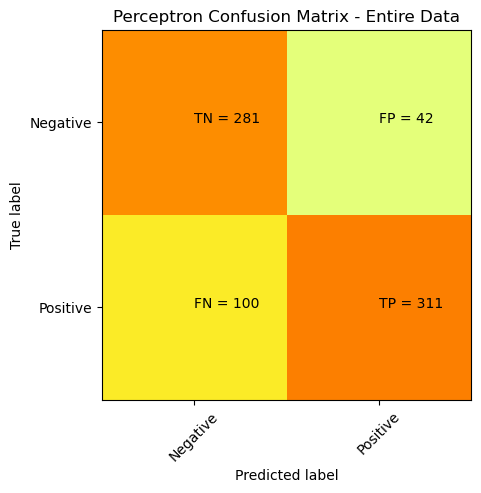

In [310]:
plt.clf() 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Perceptron Confusion Matrix - Entire Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
  
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

В принципе выглядит что перцептрон не так что бы и много ошибается

Тперь используем механизм опорных векторов для оценки линейной разделимости

In [311]:
x = features_train_ohe_scaled
y = target_train

In [312]:
svm = SVC(kernel='linear', random_state=12345)
svm.fit(x, y)

SVC(kernel='linear', random_state=12345)

In [313]:
predicted = svm.predict(x)
cm = confusion_matrix(y, predicted)

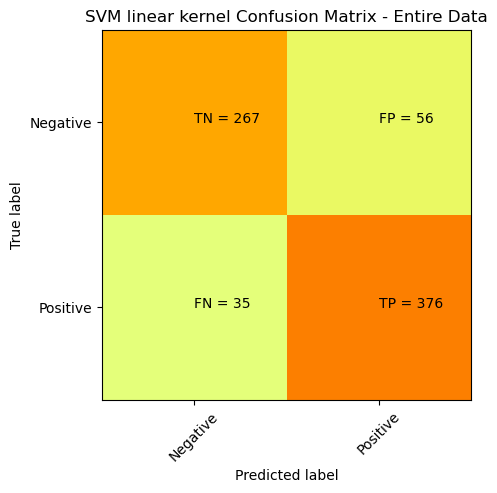

In [314]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('SVM linear kernel Confusion Matrix - Entire Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

SVM с линейным ядром также показал неплохие результаты

### Выводы: Подготовка данных для обучения модели

- Выполнили кодировку методом OHE для категориальных данных

- Выполнили стандартное масштабирование для числовых жанных

- Оценмлм необходимость балансировки классов - выглядит что соотношение классов приемлемое и балансировки не требуется

- Провели оценку линейной разделимости классов: данные выглядят достаточно хорошо линеноразделимыми и соответственно можем выбрать для базовой модели какой-то линеный классификатор, например, `LogisticRegression`

## Выбор метрики для оценки качества модели

Выберем F1 метрику как наиболее унивепсальную для задачи бинарной классификации

## Построение базовой модели

На данном этапе мы выполним следущие действия:

- обучим базовую модель `LogisticRegression` на данных без нового признака и с ним

- проверим базовую модель на адекватность

In [315]:
model = LogisticRegression(random_state=12345, max_iter=1000)

In [316]:
model.fit(features_train_ohe_scaled, target_train)

LogisticRegression(max_iter=1000, random_state=12345)

In [317]:
predicted_valid = model.predict(features_valid_ohe_scaled)

In [318]:
f1_valid = f1_score(target_valid, predicted_valid)

In [319]:
print(f1_valid)

0.8686868686868687


Выполним поиск гиперпараметров по сетке для базовой модели

In [320]:
model = LogisticRegression(random_state=12345, max_iter=1000)

In [321]:
param_grid = {
              'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [.001, .01, .1, 2, 3, 5, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    
}

In [322]:
grid_cv = GridSearchCV(model, param_grid, cv=7, n_jobs=-1, scoring="f1")

In [ ]:
_ = grid_cv.fit(features_train_ohe_scaled, target_train)

In [324]:
print(grid_cv.best_score_)

0.885277044707809


In [325]:
print(grid_cv.best_params_)

{'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}


Оценим качество на валидационной выборке

In [326]:
model = LogisticRegression(random_state=12345, max_iter=1000, **grid_cv.best_params_)

In [327]:
model.fit(features_train_ohe_scaled, target_train)

LogisticRegression(C=2, max_iter=1000, penalty='l1', random_state=12345,
                   solver='liblinear')

In [328]:
predicted_valid = model.predict(features_valid_ohe_scaled)
f1_valid = f1_score(target_valid, predicted_valid)
print(f1_valid)

0.8730964467005077


Выполним теже действия с feature engineering

In [329]:
model = LogisticRegression(random_state=12345, max_iter=1000)
model.fit(features_train_ohe_scaled_, target_train_)
predicted_valid = model.predict(features_valid_ohe_scaled_)
f1_valid = f1_score(target_valid_, predicted_valid)
print(f1_valid)

0.8787878787878788


In [ ]:
model = LogisticRegression(random_state=12345, max_iter=1000)
param_grid = {
              'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [.001, .01, .1, 2, 3, 5, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    
}
grid_cv = GridSearchCV(model, param_grid, cv=7, n_jobs=-1, scoring="f1")
_ = grid_cv.fit(features_train_ohe_scaled_, target_train_)

In [331]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.8883060606705674
{'C': 2, 'penalty': 'l1', 'solver': 'saga'}


In [332]:
model = LogisticRegression(random_state=12345, max_iter=1000, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled_, target_train_)
predicted_valid = model.predict(features_valid_ohe_scaled_)
f1_valid = f1_score(target_valid_, predicted_valid)
print(f1_valid)

0.8775510204081632


Оценим адекватность базовой модели сравнив её результаты с DummyClassifier

In [79]:
model = DummyClassifier(random_state=12345)
model.fit(features_train_ohe_scaled, target_train)
predicted_valid = model.predict(features_valid_ohe_scaled)
f1_valid = f1_score(target_valid, predicted_valid)
print(f1_valid)

0.6903914590747331


### Выводы: построние базовой модели

- Базовая модель показала неплохие результаты по целевой метрике что подтверждает неплохую линейную разделимость

- Выбранная базовая модель подтвердила свою адекватность при сравнении с DummyClassifier

## Построение целевых моделей

На данном этапе мы выполним следущие действия:

- постром несколько моделей используя различные алгоритмы обучения

- оптимизируем гиперпараметры

In [333]:
#y = data_ohe['HeartDisease']
y = target_train
y_ = target_train_

In [334]:
#X = data_ohe_scaled.drop('HeartDisease', axis=1)
X = features_train_ohe_scaled
X_ = features_train_ohe_scaled_

### SVM

In [335]:
model = SVC(random_state=12345)

In [336]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [.0001, .001, .01, 1, 3, 5, 7, 100],
    'degree': [2, 3, 5, 7],
    'gamma': ['scale', 'auto'],
    
}

In [337]:
grid_cv = GridSearchCV(model, param_grid, cv=7, n_jobs=-1, scoring="f1")

In [338]:
_ = grid_cv.fit(X, y)

In [339]:
print(grid_cv.best_score_)

0.8989461728655466


In [340]:
print(grid_cv.best_params_)

{'C': 3, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


Теперь возьмём лучшие параметры после поиска, создадим и обучим модель, а также проверим на качество на валидационной выборке

In [341]:
model = SVC(random_state=12345, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled, target_train)
predicted_valid = model.predict(features_valid_ohe_scaled)
f1_valid = f1_score(target_valid, predicted_valid)
print(f1_valid)

0.8780487804878049


Выполним теже действия с feature engineering

In [342]:
model = SVC(random_state=12345)
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [.0001, .001, .01, 1, 3, 5, 7, 100],
    'degree': [2, 3, 5, 7],
    'gamma': ['scale', 'auto'],
    
}
grid_cv = GridSearchCV(model, param_grid, cv=7, n_jobs=-1, scoring="f1")
_ = grid_cv.fit(X_, y_)

In [343]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.8932597348464695
{'C': 5, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


In [344]:
model = SVC(random_state=12345, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled_, target_train_)
predicted_valid = model.predict(features_valid_ohe_scaled_)
f1_valid = f1_score(target_valid_, predicted_valid)
print(f1_valid)

0.875


### DecisionTree

In [357]:
model = DT(random_state=12345)

In [358]:
param_grid = {
              'criterion': ['gini', 'entropy', 'log_loss'],
              'splitter': ['best', 'random'],
              'max_depth': [5, 10, 15, 20, 25, 30]
}

In [359]:
grid_cv = GridSearchCV(model, param_grid, cv=7, n_jobs=-1, scoring="f1")

In [360]:
_ = grid_cv.fit(X, y)

In [361]:
print(grid_cv.best_score_)

0.8637553471406979


In [362]:
print(grid_cv.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}


Првоерим качество на валидлационной выборке

In [363]:
model = DT(random_state=12345, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled, target_train)
predicted_valid = model.predict(features_valid_ohe_scaled)
f1_valid = f1_score(target_valid, predicted_valid)
print(f1_valid)

0.8855721393034824


Выполним теже действия с feature engineering

In [364]:
model = DT(random_state=12345)
param_grid = {
              'criterion': ['gini', 'entropy', 'log_loss'],
              'splitter': ['best', 'random'],
              'max_depth': [5, 10, 15, 20, 25, 30]
}
grid_cv = GridSearchCV(model, param_grid, cv=7, n_jobs=-1, scoring="f1")
_ = grid_cv.fit(X_, y_)

In [365]:
print(grid_cv.best_score_)

0.8693127467011823


In [366]:
print(grid_cv.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}


In [367]:
model = DT(random_state=12345, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled_, target_train_)
predicted_valid = model.predict(features_valid_ohe_scaled_)
f1_valid = f1_score(target_valid_, predicted_valid)
print(f1_valid)

0.8686868686868687


### RandomForest

In [368]:
model = RF(random_state=12345)

In [369]:
param_grid = {
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [5, 10, 15, 20],
              'n_estimators': [500, 700, 1000, 5000],
}

In [370]:
grid_cv = GridSearchCV(model, param_grid, cv=15, n_jobs=-1, scoring="f1")

In [371]:
_ = grid_cv.fit(X, y)

In [372]:
print(grid_cv.best_score_)

0.8919883880781506


In [373]:
print(grid_cv.best_params_)

{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 1000}


Првоерим качество на валидлационной выборке

In [374]:
model = RF(random_state=12345, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled, target_train)
predicted_valid = model.predict(features_valid_ohe_scaled)
f1_valid = f1_score(target_valid, predicted_valid)
print(f1_valid)

0.8932038834951457


Выполним теже действия с feature engineering

In [375]:
model = RF(random_state=12345)
param_grid = {
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [5, 10, 15, 20],
              'n_estimators': [500, 700, 1000, 5000],
}
grid_cv = GridSearchCV(model, param_grid, cv=15, n_jobs=-1, scoring="f1")
_ = grid_cv.fit(X_, y_)

In [376]:
print(grid_cv.best_score_)

0.8875319068314041


In [377]:
print(grid_cv.best_params_)

{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 1000}


In [378]:
model = RF(random_state=12345, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled_, target_train_)
predicted_valid = model.predict(features_valid_ohe_scaled_)
f1_valid = f1_score(target_valid_, predicted_valid)
print(f1_valid)

0.8921568627450981


### XGB

In [103]:
#!pip install xgboost

In [104]:
model = xgb.XGBClassifier(random_state=12345)

In [105]:
param_grid = {
              'booster': ['gbtree', 'gblinear', 'dart'],
              'eta': [.1, .3, .5],
              'max_depth': [5, 10],
              'sampling_method': ['uniform', 'subsample', 'gradient_based'],
              'tree_method': ['auto', 'exact', 'approx', 'hist'],
              'objective': ['reg:logistic', 'binary:logistic', 'binary:logitraw', 'binary:hinge'],
}

In [106]:
grid_cv = GridSearchCV(model, param_grid, cv=15, n_jobs=-1, scoring="f1")

In [ ]:
_ = grid_cv.fit(X, y)

In [108]:
print(grid_cv.best_score_)

0.8879850214565216


In [109]:
print(grid_cv.best_params_)

{'booster': 'gblinear', 'eta': 0.5, 'max_depth': 5, 'objective': 'binary:hinge', 'sampling_method': 'uniform', 'tree_method': 'auto'}


Првоерим качество на валидлационной выборке

In [110]:
model = xgb.XGBClassifier(random_state=12345, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled, target_train)
predicted_valid = model.predict(features_valid_ohe_scaled)
f1_valid = f1_score(target_valid, predicted_valid)
print(f1_valid)

[13:07:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "sampling_method", "tree_method" } are not used.

0.86


Выполним теже действия с feature engineering

In [379]:
model = xgb.XGBClassifier(random_state=12345)
aram_grid = {
              'booster': ['gbtree', 'gblinear', 'dart'],
              'eta': [.1, .3, .5],
              'max_depth': [5, 10],
              'sampling_method': ['uniform', 'subsample', 'gradient_based'],
              'tree_method': ['auto', 'exact', 'approx', 'hist'],
              'objective': ['reg:logistic', 'binary:logistic', 'binary:logitraw', 'binary:hinge'],
}
grid_cv = GridSearchCV(model, param_grid, cv=15, n_jobs=-1, scoring="f1")
_ = grid_cv.fit(X_, y_)

[14:45:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "criterion" } are not used.



In [380]:
print(grid_cv.best_score_)

0.8647734607215872


In [381]:
print(grid_cv.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 700}


In [382]:
model = xgb.XGBClassifier(random_state=12345, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled_, target_train_)
predicted_valid = model.predict(features_valid_ohe_scaled_)
f1_valid = f1_score(target_valid_, predicted_valid)
print(f1_valid)

[14:47:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "criterion" } are not used.

0.8975609756097561


### CatBoost

In [ ]:
#!pip install catboost

In [394]:
model = cat_cl(random_state=12345, verbose=False)

In [395]:
param_grid = {
              'iterations': [100, 200],
              'learning_rate': [.01, .1],
              'depth': [5, 10, 15]
}

In [396]:
grid_cv = GridSearchCV(model, param_grid, cv=7, n_jobs=-1, scoring="f1")

In [ ]:
_ = grid_cv.fit(X, y)

In [ ]:
print(grid_cv.best_score_)

In [ ]:
print(grid_cv.best_params_)

Првоерим качество на валидлационной выборке

In [ ]:
model = cat_cl(random_state=12345, verbose=False, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled, target_train)
predicted_valid = model.predict(features_valid_ohe_scaled)
f1_valid = f1_score(target_valid, predicted_valid)
print(f1_valid)

### GradientBoosting

In [383]:
model = gb_cl(random_state=12345)

In [384]:
param_grid = {
              'learning_rate': [.01, 0.1],
              'loss': ['log_loss', 'deviance', 'exponential'],
              'n_estimators': [100, 1000],
              'criterion': ['friedman_mse', 'squared_error'],
}

In [385]:
grid_cv = GridSearchCV(model, param_grid, cv=15, n_jobs=-1, scoring="f1")

In [ ]:
_ = grid_cv.fit(X, y)

In [388]:
print(grid_cv.best_score_)

0.8877411946311253


In [389]:
print(grid_cv.best_params_)

{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 1000}


Првоерим качество на валидлационной выборке

In [390]:
model = gb_cl(random_state=12345, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled, target_train)
predicted_valid = model.predict(features_valid_ohe_scaled)
f1_valid = f1_score(target_valid, predicted_valid)
print(f1_valid)

0.900990099009901


Выполним теже действия с feature engineering

In [ ]:
model = gb_cl(random_state=12345)
param_grid = {
              'learning_rate': [.01, 0.1],
              'loss': ['log_loss', 'deviance', 'exponential'],
              'n_estimators': [100, 1000],
              'criterion': ['friedman_mse', 'squared_error'],
}
grid_cv = GridSearchCV(model, param_grid, cv=15, n_jobs=-1, scoring="f1")
_ = grid_cv.fit(X_, y_)

In [392]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.8932306511534848
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}


In [393]:
model = gb_cl(random_state=12345, **grid_cv.best_params_)
model.fit(features_train_ohe_scaled_, target_train_)
predicted_valid = model.predict(features_valid_ohe_scaled_)
f1_valid = f1_score(target_valid_, predicted_valid)
print(f1_valid)

0.900990099009901
[14:44:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[14:44:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[14:44:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[14:44:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[14:44:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[14:44:34] WARNING: /Users/runner/work/xgboost/xgboost/python-packa

### Выводы: Построение целевых моделей

- GradientBoosting продемонстрировал самые лучшие способности к обучению и обобщению на представленном наборе данных

- Результаты базовой модели очень близки к результатм более сложных алгоритмов что делает её привлекательной изза своей простоты и меньших требований к вычислительной мощности

- Предложенный feature engineering немного помог LogisticRegression, XGB, GradientBoosting. Но не сильно, возможно стоит эксперементировать в данном направлении - добавить возраст в формулу.